### Pruebas para detectar pfam promedio por target en chembl

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from importlib import reload

In [2]:
import pandas as pd
import numpy as np
import collections

### Database connexion

In [3]:
# Personal login details in correct format for sqlalchemy

pepe ="sqlite:////home/fleer/Desktop/Tesis/Chembldb/chembl_27/chembl_27_sqlite/chembl_27/chembl_27_sqlite/chembl_27.db"
engine = create_engine(pepe)
CHEMBL_VERSION = 27

In [4]:
sql = '''
SELECT 
    g.chembl_id as target_chemblid, 
    source_domain_id, 
    c.chembl_id as compound_chemblid, 
    a.pchembl_value, 
    a.activity_comment
FROM
  ACTIVITIES a 
  JOIN MOLECULE_HIERARCHY b ON a.MOLREGNO = b.MOLREGNO
  JOIN MOLECULE_DICTIONARY c ON b.PARENT_MOLREGNO = c.MOLREGNO
  JOIN COMPOUND_PROPERTIES d ON b.PARENT_MOLREGNO = d.MOLREGNO
  JOIN COMPOUND_STRUCTURES e ON b.PARENT_MOLREGNO = e.MOLREGNO
  JOIN ASSAYS f ON a.ASSAY_ID = f.ASSAY_ID
  JOIN TARGET_DICTIONARY g ON f.TID = g.TID
  JOIN DOCS h ON a.DOC_ID = h.DOC_ID
  JOIN TARGET_COMPONENTS i ON g.tid = i.tid
  JOIN COMPONENT_CLASS j ON i.component_id = j.component_id
  JOIN PROTEIN_CLASSIFICATION k ON j.protein_class_id = k.protein_class_id
  JOIN component_domains ON component_domains.component_ID = i.component_ID
  JOIN domains ON domains.domain_ID = component_domains.domain_ID
  JOIN compound_records ON a.record_ID = compound_records.record_ID
WHERE
   a.pchembl_value >= 6.0
   AND (a.potential_duplicate = 0 OR a.potential_duplicate IS NULL)
   AND a.data_validity_comment IS NULL
   AND assay_type = 'B'
   AND d.psa IS NOT NULL  
UNION
SELECT 
    g.chembl_id as target_chemblid, 
    source_domain_id, 
    c.chembl_id as compound_chemblid, 
    a.pchembl_value, 
    a.activity_comment
FROM
  ACTIVITIES a 
  JOIN MOLECULE_HIERARCHY b ON a.MOLREGNO = b.MOLREGNO
  JOIN MOLECULE_DICTIONARY c ON b.PARENT_MOLREGNO = c.MOLREGNO
  JOIN COMPOUND_PROPERTIES d ON b.PARENT_MOLREGNO = d.MOLREGNO
  JOIN COMPOUND_STRUCTURES e ON b.PARENT_MOLREGNO = e.MOLREGNO
  JOIN ASSAYS f ON a.ASSAY_ID = f.ASSAY_ID
  JOIN TARGET_DICTIONARY g ON f.TID = g.TID
  JOIN DOCS h ON a.DOC_ID = h.DOC_ID
  JOIN TARGET_COMPONENTS i ON g.tid = i.tid
  JOIN COMPONENT_CLASS j ON i.component_id = j.component_id
  JOIN PROTEIN_CLASSIFICATION k ON j.protein_class_id = k.protein_class_id
  JOIN component_domains ON component_domains.component_ID = i.component_ID
  JOIN domains ON domains.domain_ID = component_domains.domain_ID
  JOIN compound_records ON a.record_ID = compound_records.record_ID
WHERE
    a.activity_comment LIKE 'Active'
   AND (a.potential_duplicate = 0 OR a.potential_duplicate IS NULL)
   AND a.data_validity_comment IS NULL
   AND assay_type = 'B'
   AND d.psa IS NOT NULL
   AND g.target_type IN ('SINGLE PROTEIN', 'PROTEIN COMPLEX');
  '''
df = pd.read_sql(sql, engine)

In [5]:
df.shape

(1694147, 5)

In [6]:
df.head()

,target_chemblid,source_domain_id,compound_chemblid,pchembl_value,activity_comment
0,CHEMBL1075021,PF00204,CHEMBL36506,7.43,None
1,CHEMBL1075021,PF00204,CHEMBL565572,6.79,None
2,CHEMBL1075021,PF00204,CHEMBL565741,6.59,None
3,CHEMBL1075021,PF00204,CHEMBL565743,6.42,None
4,CHEMBL1075021,PF00204,CHEMBL565750,7.29,None


In [7]:
df=df.drop_duplicates(subset= ['target_chemblid', 'source_domain_id', 'compound_chemblid'])
df.shape

(1452780, 5)

In [8]:
df.to_csv(r'/home/fleer/Desktop/Target_chembl/pfam_mol/pfamid_assay_df_nodup.csv') #paso intermedio

In [9]:
grouped_df = df.groupby("target_chemblid")
grouped_pfam = grouped_df["source_domain_id"].apply(list)


In [10]:
grouped_df = df.groupby("target_chemblid")
grouped_pfam = grouped_df["source_domain_id"].apply(list)
grouped_pfam = grouped_pfam.reset_index()
grouped_pfam['Domain_key']=['_'.join(sorted(set(x))) for x in grouped_pfam.source_domain_id]
grouped_pfam.head()



,target_chemblid,source_domain_id,Domain_key
0,CHEMBL1075021,"[PF00204, PF00204, PF00204, PF00204, PF00204, ...",PF00204_PF00986_PF01751_PF02518
1,CHEMBL1075022,"[PF00204, PF00204, PF00204, PF00204, PF00204, ...",PF00204_PF00986_PF01751_PF02518
2,CHEMBL1075023,"[PF01048, PF01048, PF01048]",PF01048
3,CHEMBL1075024,"[PF03060, PF03060, PF03060, PF03060, PF03060, ...",PF03060
4,CHEMBL1075025,"[PF01255, PF01255, PF01255, PF01255, PF01255, ...",PF01255


In [11]:
grouped_compound = grouped_df["compound_chemblid"].apply(list)
grouped_compound = grouped_compound.reset_index()
#grouped_compound.head()
result = pd.merge(grouped_compound, grouped_pfam,  how='left', on=['target_chemblid'])
result.head()

,target_chemblid,compound_chemblid,source_domain_id,Domain_key
0,CHEMBL1075021,"[CHEMBL36506, CHEMBL565572, CHEMBL565741, CHEM...","[PF00204, PF00204, PF00204, PF00204, PF00204, ...",PF00204_PF00986_PF01751_PF02518
1,CHEMBL1075022,"[CHEMBL565572, CHEMBL565750, CHEMBL565765, CHE...","[PF00204, PF00204, PF00204, PF00204, PF00204, ...",PF00204_PF00986_PF01751_PF02518
2,CHEMBL1075023,"[CHEMBL405346, CHEMBL405371, CHEMBL407216]","[PF01048, PF01048, PF01048]",PF01048
3,CHEMBL1075024,"[CHEMBL1206212, CHEMBL175157, CHEMBL235272, CH...","[PF03060, PF03060, PF03060, PF03060, PF03060, ...",PF03060
4,CHEMBL1075025,"[CHEMBL255828, CHEMBL256222, CHEMBL256476, CHE...","[PF01255, PF01255, PF01255, PF01255, PF01255, ...",PF01255


In [12]:
result.to_csv ( r'/home/fleer/Desktop/Target_chembl/pfam_mol/pfamid_chembl27_assay.csv')

### Analisis

In [13]:
sum_df = df.groupby("target_chemblid").count()
sum_df.head()

,source_domain_id,compound_chemblid,pchembl_value,activity_comment
target_chemblid,,,,
CHEMBL1075021,132,132,132,0
CHEMBL1075022,88,88,88,0
CHEMBL1075023,3,3,3,0
CHEMBL1075024,15,15,15,0
CHEMBL1075025,16,16,16,0


In [14]:
sum_df.shape

(5729, 4)

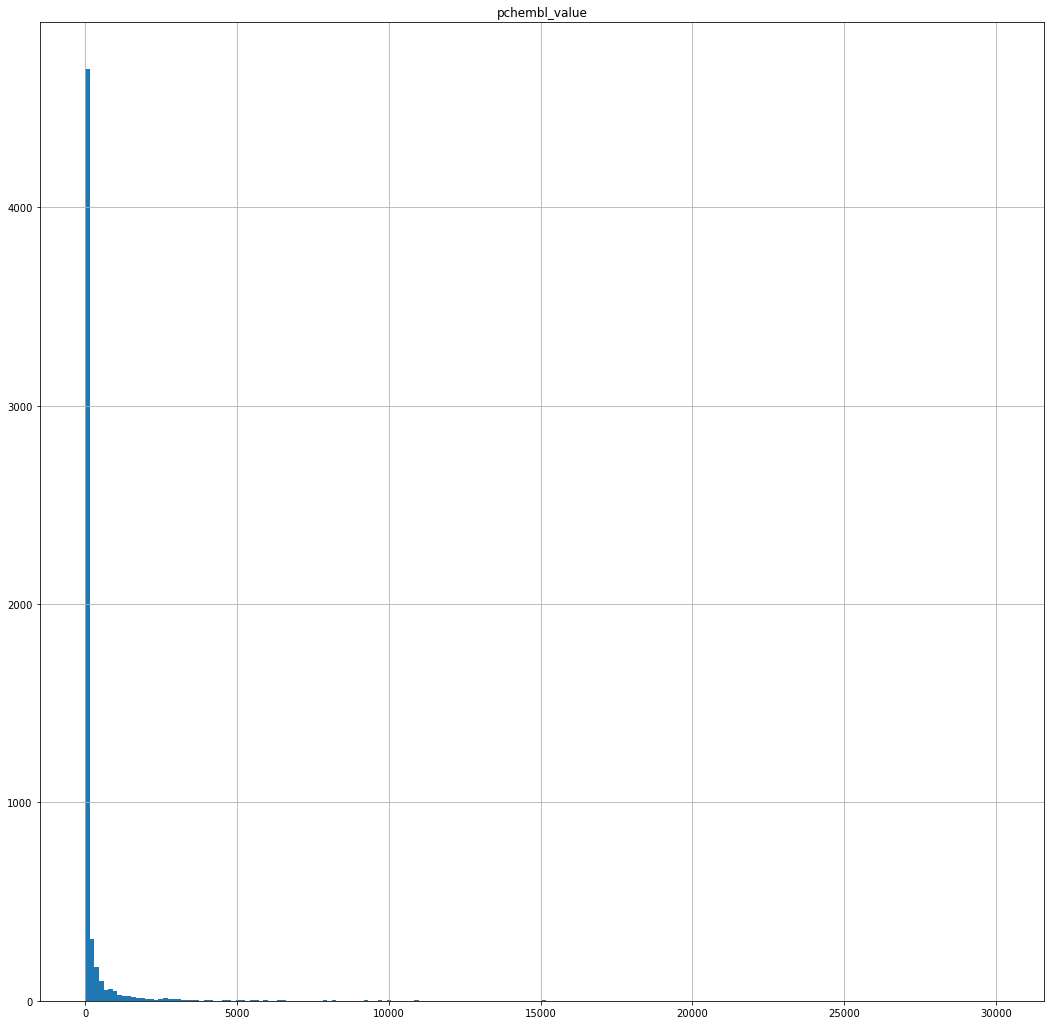

In [15]:
ax = sum_df.hist(column= 'pchembl_value', bins=200, figsize=(18, 18)) #grafico de numero de pfamid por chembl id

pre script

In [39]:
import pandas as pd
from pandas import json_normalize
import json
import argparse
import sys
import csv
from importlib import reload


base_pfam= pd.read_csv ('/home/fleer/Desktop/Target_chembl/pfam_mol/pfamid_chembl27_assay.csv')
base_pfam['compound_chemblid']=[eval(x) for x in base_pfam.compound_chemblid]
#base_pfam=result
#print(base_pfam)


In [59]:


def search_bypfam(target_domains):
    confiable=[]
   # target_domains=[]
    dudoso=[]
    if target_domains:
        for pfam_id in target_domains:
            pfam_id = pfam_id.strip()
           # target_domains.append(pfam_id)
            print(pfam_id)
            for _,record in base_pfam.iterrows():
                if record.Domain_key == pfam_id:
                    confiable+=record.compound_chemblid
                elif pfam_id in record.Domain_key:
                    dudoso+=record.compound_chemblid
        df_base_pfam=base_pfam[base_pfam.Domain_key=="_".join(sorted(set(target_domains)))] #este en una funcion aparte
        for compuestos in df_base_pfam.compound_chemblid:
            confiable=confiable + compuestos
        confiable=set(confiable)
        dudoso=set(dudoso)-confiable
    return confiable, dudoso

   
   # df = pd.read_sql(find_pfam, engine)
    #return df
c, d = search_bypfam(['PF00089' ])

PF00089


In [60]:
len(c), len(d)

(5350, 7824)

In [33]:
base_pfam['compound_chemblid']=[eval(x) for x in base_pfam.compound_chemblid]
base_pfam.compound_chemblid.iloc[0]

['CHEMBL36506',
 'CHEMBL565572',
 'CHEMBL565741',
 'CHEMBL565743',
 'CHEMBL565750',
 'CHEMBL565765',
 'CHEMBL565776',
 'CHEMBL565971',
 'CHEMBL567804',
 'CHEMBL568019',
 'CHEMBL568020',
 'CHEMBL568021',
 'CHEMBL568222',
 'CHEMBL571734',
 'CHEMBL576228',
 'CHEMBL577041',
 'CHEMBL577053',
 'CHEMBL577478',
 'CHEMBL577909',
 'CHEMBL577922',
 'CHEMBL578120',
 'CHEMBL578138',
 'CHEMBL578149',
 'CHEMBL578336',
 'CHEMBL578361',
 'CHEMBL578362',
 'CHEMBL578991',
 'CHEMBL578992',
 'CHEMBL583049',
 'CHEMBL583438',
 'CHEMBL583440',
 'CHEMBL583870',
 'CHEMBL584265',
 'CHEMBL36506',
 'CHEMBL565572',
 'CHEMBL565741',
 'CHEMBL565743',
 'CHEMBL565750',
 'CHEMBL565765',
 'CHEMBL565776',
 'CHEMBL565971',
 'CHEMBL567804',
 'CHEMBL568019',
 'CHEMBL568020',
 'CHEMBL568021',
 'CHEMBL568222',
 'CHEMBL571734',
 'CHEMBL576228',
 'CHEMBL577041',
 'CHEMBL577053',
 'CHEMBL577478',
 'CHEMBL577909',
 'CHEMBL577922',
 'CHEMBL578120',
 'CHEMBL578138',
 'CHEMBL578149',
 'CHEMBL578336',
 'CHEMBL578361',
 'CHEMBL578362',